In [2]:
!pip install tensorflow


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import os
import random
import shutil
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.use("Agg")
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix



## build_dataset.py

In [7]:
#data
ORIG_INPUT_DATASET = "cell_images"
BASE_PATH = "."
TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])
TEST_PATH = os.path.sep.join([BASE_PATH, "testing"])

# Split train/validation/test
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1

In [8]:
# Get image
mypath = "cell_images"
imagePaths = [os.path.join(dirpath,f) for (dirpath, dirnames, filenames) in 
              os.walk(mypath) for f in filenames]

# Shuffle
random.seed(42)
random.shuffle(imagePaths)

In [9]:
# Split train/test
i = int(len(imagePaths) * TRAIN_SPLIT)
trainPaths = imagePaths[:i]
testPaths = imagePaths[i:]

# Split validation 
i = int(len(trainPaths) * VAL_SPLIT)
valPaths = trainPaths[:i]
trainPaths = trainPaths[i:]


In [10]:
# Define datasets
datasets = [
    ("training", trainPaths, TRAIN_PATH),
    ("validation", valPaths, VAL_PATH),
    ("testing", testPaths, TEST_PATH)
]

# Copy data
for (dType, imagePaths, baseOutput) in datasets:
    print(f"[INFO] building '{dType}' split")
    
    # Create output directory if it doesn't exist
    if not os.path.exists(baseOutput):
        print(f"[INFO] 'creating {baseOutput}' directory")
        os.makedirs(baseOutput)
    
    # Iterate through image paths
    for inputPath in imagePaths:
        filename = inputPath.split(os.path.sep)[-1]
        label = inputPath.split(os.path.sep)[-2]
        
        # Label directory path
        labelPath = os.path.sep.join([baseOutput, label])
        
        # Create label directory if it doesn't exist
        if not os.path.exists(labelPath):
            print(f"[INFO] 'creating {labelPath}' directory")
            os.makedirs(labelPath)
            
        # Copy image
        p = os.path.sep.join([labelPath, filename])
        shutil.copy2(inputPath, p)

[INFO] building 'training' split
[INFO] 'creating ./training' directory
[INFO] 'creating ./training/Parasitized' directory
[INFO] 'creating ./training/Uninfected' directory
[INFO] 'creating ./training/cell_images' directory
[INFO] building 'validation' split
[INFO] 'creating ./validation' directory
[INFO] 'creating ./validation/Uninfected' directory
[INFO] 'creating ./validation/Parasitized' directory
[INFO] building 'testing' split
[INFO] 'creating ./testing' directory
[INFO] 'creating ./testing/Parasitized' directory
[INFO] 'creating ./testing/Uninfected' directory


## train_model.py

In [79]:

# data counts
totalTrain = len([os.path.join(dirpath,f) for (dirpath, dirnames, filenames) in 
              os.walk(TRAIN_PATH) for f in filenames])
totalVal = len([os.path.join(dirpath,f) for (dirpath, dirnames, filenames) in 
              os.walk(VAL_PATH) for f in filenames])
totalTest = len([os.path.join(dirpath,f) for (dirpath, dirnames, filenames) in 
              os.walk(TEST_PATH) for f in filenames])


In [49]:
# ImageDataGenerator
BS = 32
trainAug = ImageDataGenerator(rescale=1 / 255.0)
valAug = ImageDataGenerator(rescale=1 / 255.0)

trainGen = trainAug.flow_from_directory(
    TRAIN_PATH,
    class_mode="binary",
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=BS)

valGen = valAug.flow_from_directory(
    VAL_PATH,
    class_mode="binary",
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=BS)

testGen = valAug.flow_from_directory(
    TEST_PATH,
    class_mode="binary",
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=BS)

print("Class indices:", trainGen.class_indices)

Found 19842 images belonging to 3 classes.
Found 2204 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.
Class indices: {'Parasitized': 0, 'Uninfected': 1, 'cell_images': 2}


In [51]:
# VGG16 model
conv_base = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(150, 150, 3)
)
print("VGG16 model loaded successfully")

VGG16 model loaded successfully


In [53]:
# data shape
print("Feature extraction shapes:")
print(f"Expected training feature shape: ({totalTrain}, 4, 4, 512)")
print(f"Expected validation feature shape: ({totalVal}, 4, 4, 512)")
print(f"Expected test feature shape: ({totalTest}, 4, 4, 512)")

Feature extraction shapes:
Expected training feature shape: (19842, 4, 4, 512)
Expected validation feature shape: (2204, 4, 4, 512)
Expected test feature shape: (5512, 4, 4, 512)


In [55]:
# Define feature extraction function
def extract_features(generator, total_samples, desc):
    features = np.zeros(shape=(total_samples, 4, 4, 512))
    labels = np.zeros(shape=(total_samples))
    
    processed_samples = 0
    
    print(f"Extracting {desc} features...")
    
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        current_batch_size = inputs_batch.shape[0]
        
        if processed_samples + current_batch_size > total_samples:
            remaining = total_samples - processed_samples
            features[processed_samples : total_samples] = features_batch[:remaining]
            labels[processed_samples : total_samples] = labels_batch[:remaining]
            break
        else:
            features[processed_samples : processed_samples + current_batch_size] = features_batch
            labels[processed_samples : processed_samples + current_batch_size] = labels_batch
        
        processed_samples += current_batch_size
        if processed_samples >= total_samples:
            break
            
        if processed_samples % 1000 == 0:
            print(f"Processed {processed_samples}/{total_samples} {desc} images")
    
    return features, labels

# Extract and save features for each dataset
print("Starting feature extraction")
train_features, train_labels = extract_features(trainGen, totalTrain, "training")
val_features, val_labels = extract_features(valGen, totalVal, "validation")
test_features, test_labels = extract_features(testGen, totalTest, "testing")

# Save extracted features
np.save('train_features.npy', train_features)
np.save('train_labels.npy', train_labels)
np.save('val_features.npy', val_features)
np.save('val_labels.npy', val_labels)
np.save('test_features.npy', test_features)
np.save('test_labels.npy', test_labels)

Starting feature extraction
Extracting training features...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 

In [56]:
# load f
train_features = np.load('train_features.npy')
train_labels = np.load('train_labels.npy')
val_features = np.load('val_features.npy')
val_labels = np.load('val_labels.npy')
test_features = np.load('test_features.npy')
test_labels = np.load('test_labels.npy')

# data shapes
print("Training features shape:", train_features.shape)
print("Validation features shape:", val_features.shape)
print("Testing features shape:", test_features.shape)

Training features shape: (19842, 4, 4, 512)
Validation features shape: (2204, 4, 4, 512)
Testing features shape: (5512, 4, 4, 512)


In [57]:
# flatten feature data
train_features_flat = np.reshape(train_features, (train_features.shape[0], -1))
val_features_flat = np.reshape(val_features, (val_features.shape[0], -1))
test_features_flat = np.reshape(test_features, (test_features.shape[0], -1))

print("Flattened training features shape:", train_features_flat.shape)

Flattened training features shape: (19842, 8192)


In [58]:
# Define classifier model
model = Sequential([
    Dense(512, activation='relu', input_dim=train_features_flat.shape[1]),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='binary_crossentropy',
             metrics=['accuracy'])


model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,326,401 (16.50 MB)

 Trainable params: 4,326,401 (16.50 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_malaria_model.keras',
    monitor='val_accuracy',
    save_best_only=True
)


In [60]:
# Train model
history = model.fit(
    train_features_flat,
    train_labels,
    batch_size=32,
    epochs=100,
    validation_data=(val_features_flat, val_labels),
    callbacks=[early_stopping, checkpoint]
)

# Save final model
model.save('final_malaria_model.keras')
print("Final model saved successfully!")

Epoch 1/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7833 - loss: 0.4407 - val_accuracy: 0.9170 - val_loss: 0.2125
Epoch 2/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9113 - loss: 0.2237 - val_accuracy: 0.9301 - val_loss: 0.1857
Epoch 3/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9233 - loss: 0.2003 - val_accuracy: 0.9301 - val_loss: 0.1820
Epoch 4/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9309 - loss: 0.1770 - val_accuracy: 0.9319 - val_loss: 0.1823
Epoch 5/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9363 - loss: 0.1715 - val_accuracy: 0.9378 - val_loss: 0.1774
Epoch 6/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9399 - loss: 0.1677 - val_accuracy: 0.9392 - val_loss: 0.1788
Epoch 7/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9393 - loss: 0.1595 - val_accuracy: 0.9401 - val_loss: 0.1722
Epoch 8/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9485 - loss: 0.1464 - val_accu

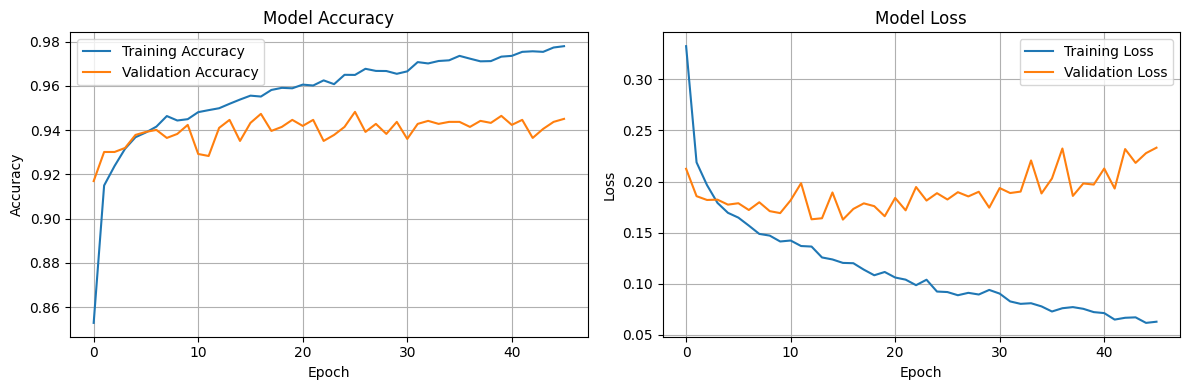

In [61]:
%matplotlib inline
plt.close('all')

plt.figure(figsize=(12, 4))

# accuracy graph
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# loss graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [62]:
# Evaluate test accuracy
test_loss, test_accuracy = model.evaluate(test_features_flat, test_labels)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
print(f"Target Accuracy to Beat: 93.7%")
if test_accuracy * 100 > 93.7:
    print("Success! Model exceeded target accuracy!")
else:
    print("Model did not reach target accuracy. Consider using data augmentation.")

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9484 - loss: 0.1664

Test Accuracy: 94.68%
Target Accuracy to Beat: 93.7%
Success! Model exceeded target accuracy!


173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


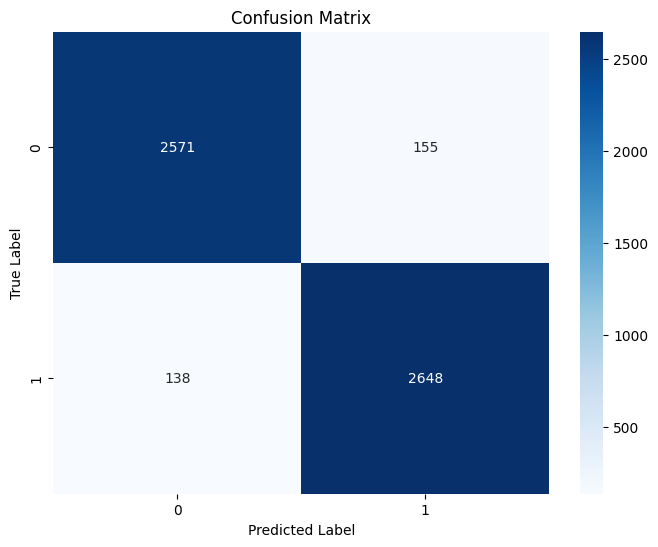

In [63]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generate predictions
y_pred = model.predict(test_features_flat)
y_pred_classes = (y_pred > 0.5).astype(int)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(test_labels, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [64]:
# Detailed classification report
print("\nClassification Report:")
print(classification_report(test_labels, y_pred_classes, 
                          target_names=['Uninfected', 'Parasitized']))


Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.95      0.94      0.95      2726
 Parasitized       0.94      0.95      0.95      2786

    accuracy                           0.95      5512
   macro avg       0.95      0.95      0.95      5512
weighted avg       0.95      0.95      0.95      5512



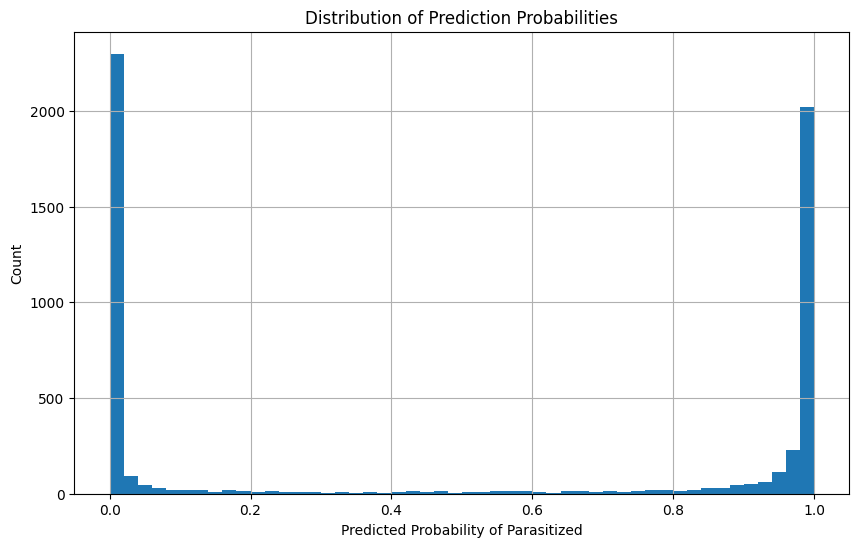

In [65]:
# Visualize prediction probability distribution
plt.figure(figsize=(10, 6))
plt.hist(y_pred, bins=50)
plt.title('Distribution of Prediction Probabilities')
plt.xlabel('Predicted Probability of Parasitized')
plt.ylabel('Count')
plt.grid(True)
plt.show()